In [2]:
from transformers import CLIPVisionModel, CLIPImageProcessor, StoppingCriteria, CLIPModel
from torchvision.transforms.functional import InterpolationMode
from torchvision import transforms
import os
import sys
sys.path.append("./")
from pink import *
import base64
import pandas as pd
import numpy as np
import torch
import json

import io
from PIL import Image
import random
import math
from pink.datasets.Templates import ChoiceQuestionAnswer
from pink.conversation import conv_llava_v1, conv_simple_v1_mmbench, conv_llama2, conv_simple_v1
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

: 

In [3]:
model_name = "/lustre/Katherine/Pink/Pink_object365"
config = AutoConfig.from_pretrained(model_name, use_cache=True)
config.llama_path = ""
if config.llama_path != model_name:
    # need to merge parameters
    llama_path = '/lustre/Katherine/Pink/Llama-2-7b-chat-hf_2'
    weight_map_index = json.load(open(os.path.join("/lustre/Katherine/Pink/Llama-2-7b-chat-hf_2", "pytorch_model.bin.index.json"), "r"))
    shard_files = list(set(weight_map_index["weight_map"].values()))
    loaded_keys = weight_map_index["weight_map"].keys()
    state_dict = {}
    for index, shard_file in enumerate(shard_files):
        state_dict.update(torch.load(os.path.join(llama_path, shard_file), map_location="cpu"))
    peft_parameters = torch.load(os.path.join(model_name, "saved_parameters.pth"), map_location="cpu")
    for k, v in peft_parameters.items():
        state_dict[k] = v
else:
    state_dict = None

model = AutoModelForCausalLM.from_pretrained(None, config=config, state_dict=state_dict)
for name, param in model.model.named_parameters():
    if not ("adapter_" in name or "lora_" in name):
        param.data = param.data.half()
model.lm_head.to(torch.float16)
model = model.cuda()

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, padding_side='left')

Some weights of CLIPVisionInitModel were not initialized from the model checkpoint at /lustre/Katherine/Pink/clip-vit-large-patch14 and are newly initialized: ['vision_model.encoder.layers.0.adapter_attn.tune_adapter_a.bias', 'vision_model.encoder.layers.0.adapter_attn.tune_adapter_a.weight', 'vision_model.encoder.layers.0.adapter_attn.tune_adapter_b.bias', 'vision_model.encoder.layers.0.adapter_attn.tune_adapter_b.weight', 'vision_model.encoder.layers.1.adapter_attn.tune_adapter_a.bias', 'vision_model.encoder.layers.1.adapter_attn.tune_adapter_a.weight', 'vision_model.encoder.layers.1.adapter_attn.tune_adapter_b.bias', 'vision_model.encoder.layers.1.adapter_attn.tune_adapter_b.weight', 'vision_model.encoder.layers.10.adapter_attn.tune_adapter_a.bias', 'vision_model.encoder.layers.10.adapter_attn.tune_adapter_a.weight', 'vision_model.encoder.layers.10.adapter_attn.tune_adapter_b.bias', 'vision_model.encoder.layers.10.adapter_attn.tune_adapter_b.weight', 'vision_model.encoder.layers.11.

In [4]:
from pink.conversation import conv_llama2
image_processor = transforms.Compose(
    [
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
image_token_len = model.config.num_patches

model.eval()
conv = conv_llama2.copy()
DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"
PREFIX_IMAGE = "Image: "
PREFIX_NO_IMAGE = "Image: N/A"
BEGIN_DESCRIPTION = "<des>"
END_DESCRIPTION = "</des>"
BEGIN_LOC = "<loc>"
END_LOC = "</loc>"
BEGIN_CLS = "<cls>"
END_CLS = "</cls>"
BEGIN_RELATION = "<rel>"
END_RELATION = "</rel>"
BEGIN_QUESTION = "<qes>"
END_QUESTION = "</qes>"
DEFAULT_EOS_TOKEN = "</s>"

In [7]:
import re
from PIL import ImageDraw
from matplotlib import pyplot as plt

image_path = "/data/Katherine/data/FGVC-Aircraft/fgvc-aircraft-2013b/data/images/0062134.jpg"
question = "这是什么建筑?"


/home/wz/anaconda3/envs/pink/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <<SYS>>
Image: <im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patc

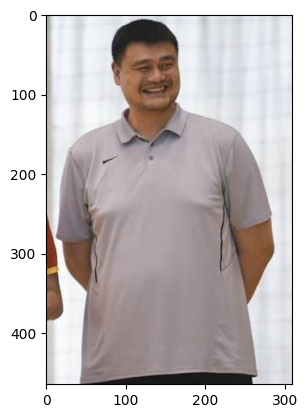

: 

In [8]:
loc_pattern = re.compile(r"(\[[0-9].[0-9][0-9][0-9],[0-9].[0-9][0-9][0-9],[0-9].[0-9][0-9][0-9],[0-9].[0-9][0-9][0-9]\])")
bbox_pattern = re.compile(r"[0-9].[0-9][0-9][0-9]")

with open(image_path, "rb") as f:
    image = Image.open(io.BytesIO(f.read())).convert('RGB')
width, height = image.size

copy_image1 = image.copy()

image_tensor = image_processor(image)
images = image_tensor.unsqueeze(0).cuda()
conv.messages = []
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
conv.set_system(PREFIX_IMAGE + image_token_len * DEFAULT_IMAGE_PATCH_TOKEN)
cur_prompt = conv.get_prompt()
print(cur_prompt)

tokenized_output = tokenizer(
    [cur_prompt],
    return_tensors="pt",
    padding="longest",
    max_length=tokenizer.model_max_length,
    truncation=True,
)

input_ids = torch.as_tensor(tokenized_output.input_ids).cuda()
attention_mask = torch.as_tensor(tokenized_output.attention_mask).cuda()

with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images,
        has_images=[True],
        attention_mask=attention_mask,
        do_sample=False,
        num_beams=1,
        temperature=0.7,
        max_new_tokens=1024,
    )

for input_id, output_id in zip(input_ids, output_ids):
    input_token_len = input_id.shape[0]
    n_diff_input_output = (input_id != output_id[:input_token_len]).sum().item()
    if n_diff_input_output > 0:
        print(f'[Warning] Sample {i}: {n_diff_input_output} output_ids are not the same as the input_ids')
    output = tokenizer.batch_decode(output_id[input_token_len:].unsqueeze(0), skip_special_tokens=True)[0]
    output = output.strip()
    print(output)

loc_token = loc_pattern.findall(output)

colors = [(0,0,255),(255,0,0),(0,255,0),(255,0,255),(255,255,0),(255,255,255),(0,0,0)]
for loc_id, loc in enumerate(loc_token):
    bbox = bbox_pattern.findall(loc)
    assert len(bbox) == 4
    scaled_bbox = [float(bbox[0])*width,float(bbox[1])*height,float(bbox[2])*width,float(bbox[3])*height]
    draw1 = ImageDraw.Draw(copy_image1)
    draw1.rectangle(scaled_bbox, fill=None, outline=colors[loc_id], width=5)
plt.imshow(copy_image1)
